# Controlled integrator 2

This demo implements a controlled one-dimensional neural integrator
that is functionally the same as
the controlled integrator in the previous example.
However, the control signal is zero for integration,
less than one for low-pass filtering, and greater than 1 for saturation.
This behavior maps more directly to the differential equation
used to describe an integrator:

$$\dot{x} = \mathrm{Ax}(t) + \mathrm{Bu}(t)$$

The control in this circuit is $A$ in that equation.
This is also the controlled integrator
described in the book "How to build a brain."

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise

## Step 1: Create the network

As before, we use standard network-creation commands
to begin creating our controlled integrator.
An ensemble of neurons will represent the state of our integrator,
and the connections between the neurons in the ensemble
will define the dynamics of our integrator.

In [2]:
model = nengo.Network(label="Controlled Integrator 2")
with model:
    # Make a population with 225 LIF neurons representing a 2 dimensional
    # signal, with a larger radius to accommodate large inputs
    A = nengo.Ensemble(225, dimensions=2, radius=1.5)

## Step 2: Define the 'input' signal to integrate

We will be running 1 second of simulation time again,
so we will use the same Python function `input_func`
to define our input signal. This piecewise function sits at 0
until .2 seconds into the simulation,
then jumps up to 5, back to 0, down to -10, back to 0, then up to 5,
and then back to 0. Our integrator will respond by ramping up
when the input is positive, and descending when the input is negative.

In [3]:
with model:
    # Create a piecewise step function for input
    input_func = Piecewise({0.2: 5, 0.3: 0, 0.44: -10, 0.54: 0, 0.8: 5, 0.9: 0})
    inp = nengo.Node(output=input_func)

    # Connect the Input signal to ensemble A.
    tau = 0.1
    nengo.Connection(inp, A, transform=[[tau], [0]], synapse=0.1)

## Step 3: Define the control signal

The control signal will be 0 for the first part of the simulation,
and -0.5 for the second part.
This means that at the beginning of the simulation,
the integrator will act as an optimal integrator,
and partway though the simulation (at t = 0.6),
it will switch to being a leaky integrator.

In [4]:
with model:
    # Another piecewise function that changes half way through the run
    control_func = Piecewise({0: 0, 0.6: -0.5})
    control = nengo.Node(output=control_func)

    # Connect the "Control" signal to the second of A's two input channels
    nengo.Connection(control, A[1], synapse=0.005)

## Step 4: Define the integrator dynamics

We set up integrator by connecting population 'A' to itself.
We set up feedback in the model to handle integration of the input.
The time constant $\tau$ on the recurrent weights
affects both the rate and accuracy of integration.

In [5]:
with model:
    # Note the changes from the previous example to the function being defined.
    nengo.Connection(A, A[0], function=lambda x: x[0] * x[1] + x[0], synapse=tau)

    # Record both dimensions of A
    A_probe = nengo.Probe(A, "decoded_output", synapse=0.01)

## Step 5: Run the model and plot results

In [6]:
with nengo.Simulator(model) as sim:  # Create a simulator
    sim.run(1.4)  # Run for 1.4 seconds

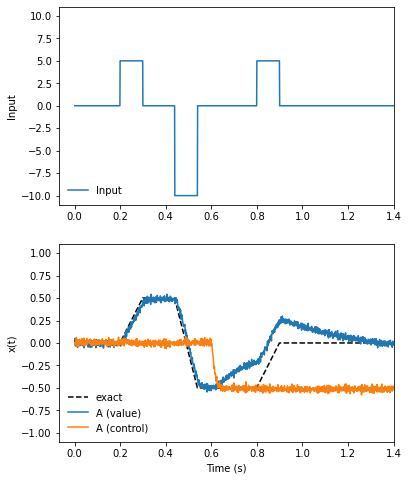

In [7]:
# Plot the value and control signals, along with the exact integral
t = sim.trange()
dt = t[1] - t[0]
input_sig = input_func.run(t[-1], dt=dt)
control_sig = control_func.run(t[-1], dt=dt)
ref = dt * np.cumsum(input_sig)

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(t, input_sig, label="Input")
plt.xlim(right=t[-1])
plt.ylim(-11, 11)
plt.ylabel("Input")
plt.legend(loc="lower left", frameon=False)

plt.subplot(212)
plt.plot(t, ref, "k--", label="exact")
plt.plot(t, sim.data[A_probe][:, 0], label="A (value)")
plt.plot(t, sim.data[A_probe][:, 1], label="A (control)")
plt.xlim(right=t[-1])
plt.ylim(-1.1, 1.1)
plt.xlabel("Time (s)")
plt.ylabel("x(t)")
plt.legend(loc="lower left", frameon=False)

The above plot shows the output of our system,
specifically the (integrated) value stored by the A population,
along with the control signal represented by the A population.
The exact value of the integral,
as performed by a perfect (non-neural) integrator,
is shown for reference.

When the control value is 0 (t < 0.6),
the neural integrator performs near-perfect integration.
However, when the control value drops to -0.5 (t > 0.6),
the integrator becomes a leaky integrator.
This means that with negative input,
its stored value drifts towards zero.